In [1]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import sys
import os
import glob
from tqdm.auto import tqdm

import plotnine
from plotnine import *

In [2]:
from google.colab import drive
drive.mount('/content/G_drive')

# cp tokens
!mkdir /root/.config/earthengine/
!cp '/content/G_drive/MyDrive/Colab Notebooks/Google_Earth_Engine_tokes/credentials' /root/.config/earthengine/credentials 

# authenticate earthengine api
ee.Initialize()

Mounted at /content/G_drive


In [3]:
# change dir, append sys_path
cwd = '/content/G_drive/MyDrive/Colab Notebooks/Paper_3/Earth_Engine_codes/Step_3_Scenarios'
os.chdir(cwd)


# import custom moduls
sys.path.append('./')

In [4]:
os.path.relpath('/content/G_drive/MyDrive/Colab Notebooks/Paper_3/Earth_Engine_codes/Step_2_Sort_GAEZ_layers/Modules')

'../Step_2_Sort_GAEZ_layers/Modules'

In [5]:
# import custom moduls
sys.path.append('../Step_2_Sort_GAEZ_layers/Modules')

from Parallize_df import parallelize_dataframe

### Compute future crop production:

#### 1) use GYGA as crop yield increament

In [6]:
# read future production csv
future_production = pd.read_csv('../Step_2_Sort_GAEZ_layers/result_csv/future_production.csv')

# read future yeild-multipler
future_yield_multiplier = pd.read_csv('./result_csv/future_yield_ratios.csv')

##### Built a dict which presents the cities in each province

In [7]:
# get the citynames of each province

# 1) import GEE-Asset
NCP_provinces = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")
NCP_cities = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_city_boundary")\
         .map(lambda fe: ee.Feature(fe).centroid())

# 2) get the cities in each provinces
save_all_join = ee.Join.saveAll(matchesKey = 'cities')
geom_fitler = ee.Filter.contains('.geo',None,'.geo')

cities_gee = save_all_join.apply(NCP_provinces,NCP_cities,geom_fitler).getInfo()['features']

# 3) extract city names from each province
procince_city_dict = {i['properties']['EN_Name']:[j['properties']['CityNameC'] for j in i['properties']['cities']] 
                      for i in cities_gee}

##### Connect future_yield (RCP) with future_yield_ratio (agricultural development)

In [8]:
# function to return province name given a city name
def get_city_from_province(city):
  for p,cities in procince_city_dict.items():
    if city in cities:
      return p
      break

# add province info
future_production['zone'] = future_production['CityNameC'].apply(lambda x:get_city_from_province(x))

In [9]:
# connect future_yield with agricultural development (multiply ratios)

# 1) link two dfs
future_production_GYGA = future_production.copy().merge(right=future_yield_multiplier.copy(),on=['zone','crop','water','year'])

# 2) compute the future crop production (future_production  * agricultural_development_ratios)
future_production_GYGA['future_production_GYGA'] = future_production_GYGA['expansion_led_farmland'] * future_production_GYGA['mean_ratio']

# 3) compute the confidence interval of crop production  under [urban_development * agricultural_development]
future_production_GYGA['future_production_GYGA_obs_ci'] = future_production_GYGA['future_production_obs_ci']  * (1 + future_production_GYGA['mean_ratio']) 
future_production_GYGA['ymin'] = future_production_GYGA['future_production_GYGA'] - future_production_GYGA['future_production_GYGA_obs_ci']
future_production_GYGA['ymax'] = future_production_GYGA['future_production_GYGA'] + future_production_GYGA['future_production_GYGA_obs_ci']

# 4) select only necessary cols
future_production_GYGA = future_production_GYGA[['zone','crop','water','year','ssp','rcp','future_production_GYGA','ymin','ymax']]

# 5) compute the total production
future_production_GYGA_total = future_production_GYGA.groupby(['year','ssp','rcp']).sum().reset_index()

In [10]:
# import the total_production without yeild_increament
future_yield_multiplier = pd.read_csv('../Step_2_Sort_GAEZ_layers/result_csv/future_production_total.csv')

# reorder the rcp, which will be shown in the plot
future_production_GYGA_total['rcp'] = future_production_GYGA_total['rcp'].astype('category')
future_production_GYGA_total['rcp'] = future_production_GYGA_total['rcp'].cat.reorder_categories([85, 60, 45, 26])

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


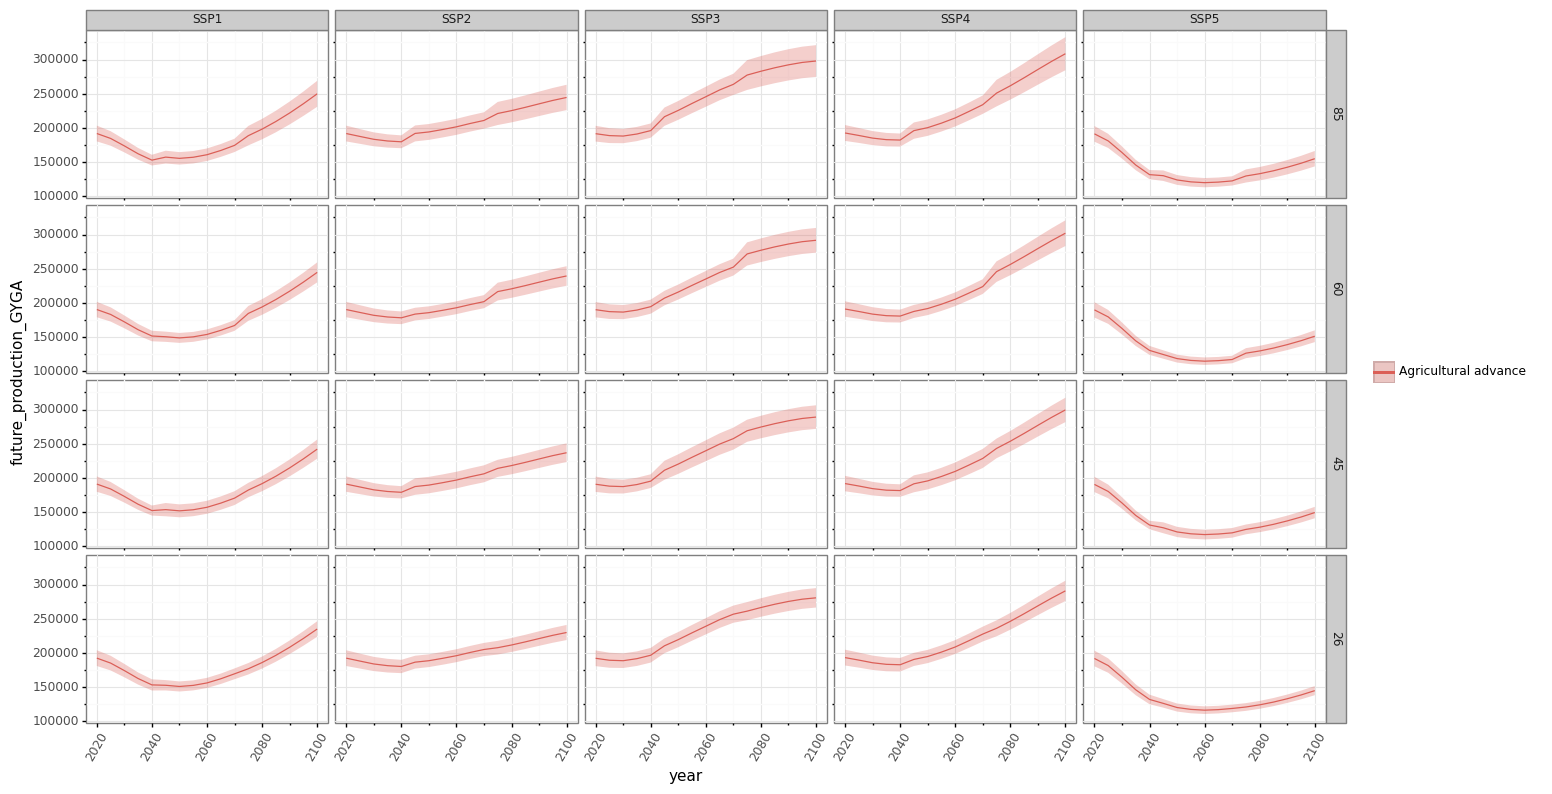

<ggplot: (8745010813905)>

In [11]:
plotnine.options.figure_size = (16, 9)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(future_production_GYGA_total, aes('year','future_production_GYGA',color=['Agricultural advance'])) +
 geom_ribbon(future_production_GYGA_total, aes('year',ymin='ymin',ymax='ymax',fill=['Agricultural advance']),alpha=0.3) +
#  geom_line(future_yield_multiplier, aes('year','expansion_led_production',color=['Yield-2010 unchanged'])) +
#  geom_ribbon(future_yield_multiplier, aes('year',ymin='ymin',ymax='ymax',fill=['Yield-2010 unchanged']),alpha=0.3) +
 facet_grid('rcp~ssp') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=60),legend_title = element_blank()))

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


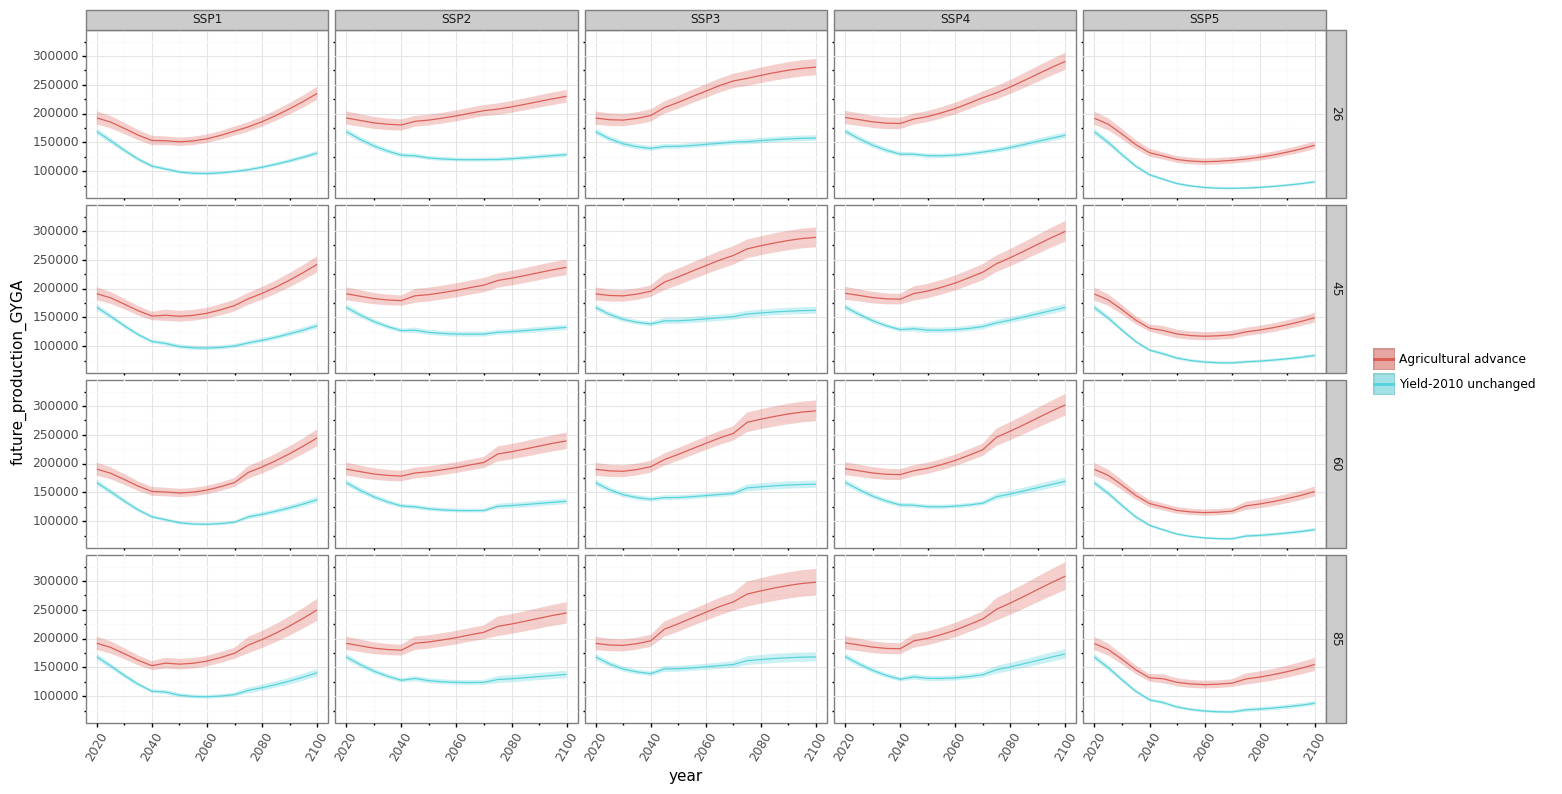

<ggplot: (8749363264205)>

In [ ]:
plotnine.options.figure_size = (16, 9)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(future_production_GYGA_total, aes('year','future_production_GYGA',color=['Agricultural advance'])) +
 geom_ribbon(future_production_GYGA_total, aes('year',ymin='ymin',ymax='ymax',fill=['Agricultural advance']),alpha=0.3) +
 geom_line(future_yield_multiplier, aes('year','expansion_led_production',color=['Yield-2010 unchanged'])) +
 geom_ribbon(future_yield_multiplier, aes('year',ymin='ymin',ymax='ymax',fill=['Yield-2010 unchanged']),alpha=0.3) +
 facet_grid('rcp~ssp') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=60),legend_title = element_blank()))

#### 2) use GAEZ as crop yield increament

In [ ]:
# get the admin shp
NCP_provinces = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# get the GAEZ pixel size
GAEZ_pix_scale = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical").projection().nominalScale().getInfo()

In [ ]:
# read the crop_yield_increament and future_harvested_area
GAEZ_future_yield = pd.read_pickle('./result_csv/GAEZ_future_yield_df.pkl')
future_framland_area = pd.read_pickle('../Step_2_Sort_GAEZ_layers/result_csv/future_harvested_area.pkl')[['crop','water','year','Scenario','future_farmland_area']]

# mosaic the yield imgs in the same year into one single img
GAEZ_future_tuple = GAEZ_future_yield.groupby(['year']).apply(lambda x,idx: (x['crop'].tolist()[0],
                                          x['water'].tolist()[0],
                                          x['year'].tolist()[0],
                                          ee.ImageCollection(x['yield_img'].tolist()).mosaic(),
                                          ee.ImageCollection(x['yield_img_obs_upper'].tolist()).mosaic(),
                                          ee.ImageCollection(x['yield_img_obs_lower'].tolist()).mosaic()),1)
GAEZ_future_df = pd.DataFrame(GAEZ_future_tuple.tolist())
GAEZ_future_df.columns = ['crop','water','year','yield_img','yield_img_obs_upper','yield_img_obs_lower']

In [ ]:
# append GAEZ_future_yield to future_farmland area
yiled_merge_area = future_framland_area.merge(GAEZ_future_df,on=['crop','water','year'])

# function to compute the total crop production

In [ ]:
yiled_merge_area.head()

,crop,water,year,Scenario,future_farmland_area,yield_img,yield_img_obs_upper,yield_img_obs_lower
0,Maize,Rainfed,2020,SSP1,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,Maize,Rainfed,2020,SSP2,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,Maize,Rainfed,2020,SSP3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,Maize,Rainfed,2020,SSP4,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,Maize,Rainfed,2020,SSP5,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


In [ ]:
# function to retrive stats using reduceRegions
def reduce_regions(img):
  stats = img.reduceRegions(collection=NCP_provinces,reducer='sum',scale=GAEZ_pix_scale).getInfo()
  stats_dict = {i['properties']['EN_Name']:i['properties']['expansion_led_farmland'] for i in stats['features']}
  return stats_dict

# function to compute the total production
def compute_production_sum(df):

  # hack to show the progres bar in multiprocessing
  print(' ',end="")

  stat = {}
  
  for idx,row in tqdm(df.iterrows(),total=len(df)):
    crop = row['crop']
    water = row['water']
    year = row['year']
    ssp = row['Scenario']

    production   = row['future_farmland_area'].multiply(row['yield_img'])
    production_min = row['future_farmland_area'].multiply(row['yield_img_obs_lower'])
    production_max = row['future_farmland_area'].multiply(row['yield_img_obs_upper'])

    stat[crop,water,year,ssp,'production'] = reduce_regions(production)
    stat[crop,water,year,ssp,'production_min'] = reduce_regions(production_min)
    stat[crop,water,year,ssp,'production_max'] = reduce_regions(production_max)

  stat_df = pd.DataFrame(pd.DataFrame(stat).T.stack()).reset_index()
  stat_df.columns = ['crop','water','year','ssp','type','zone','production']
  return stat_df

In [ ]:
# parallize the df to reduce computation time
future_production = parallelize_dataframe(yiled_merge_area,compute_production_sum,30)

In [ ]:
future_production

,crop,water,year,ssp,type,zone,production
0,Maize,Rainfed,2020,SSP1,production,Shandong,2935.223642
1,Maize,Rainfed,2020,SSP1,production,Henan,3282.587300
2,Maize,Rainfed,2020,SSP1,production,Beijing,86.983351
3,Maize,Rainfed,2020,SSP1,production,Tianjin,148.883858
4,Maize,Rainfed,2020,SSP1,production,Hebei,2521.589052
...,...,...,...,...,...,...,...
37,Maize,Rainfed,2100,SSP5,production_max,Beijing,242.322478
38,Maize,Rainfed,2100,SSP5,production_max,Tianjin,36.781824
39,Maize,Rainfed,2100,SSP5,production_max,Hebei,3375.777808
40,Maize,Rainfed,2100,SSP5,production_max,Anhui,363.426795


In [ ]:
GAEZ_future_production = pd.DataFrame(future_production.groupby(['year','ssp','type']).sum().reset_index())
GAEZ_future_production = GAEZ_future_production.pivot(index=['year','ssp'],columns='type',values='production').reset_index()
GAEZ_future_production.head()

type,year,ssp,production,production_max,production_min
0,2020,SSP1,10721.819363,12122.768976,9320.869749
1,2020,SSP2,10712.568658,12112.465882,9312.671435
2,2020,SSP3,10689.426276,12086.680185,9292.172368
3,2020,SSP4,10791.363998,12200.207823,9382.520172
4,2020,SSP5,10678.573862,12074.584041,9282.563683


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


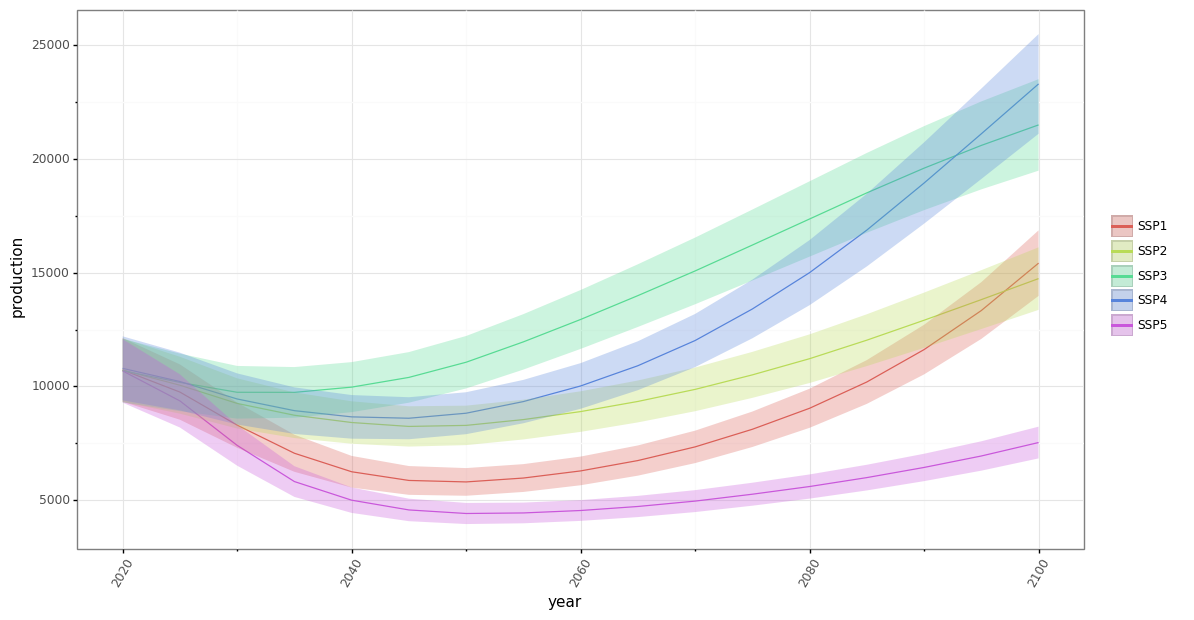

<ggplot: (8749340991285)>

In [ ]:
plotnine.options.figure_size = (13, 7)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(GAEZ_future_production, aes('year','production',color='ssp')) +
 geom_ribbon(GAEZ_future_production, aes('year',ymin='production_min',ymax='production_max',fill='ssp'),alpha=0.3) +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=60),legend_title = element_blank()))